In [6]:
import pandas as pd
import datetime
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib
import time
import numpy as np
import os
from sklearn.preprocessing import MinMaxScaler
%matplotlib inline
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [7]:
DATASET_PATH = "./dataset/TSLA.csv"

In [8]:
def parse(x):
    return datetime.datetime.strptime(x, '%Y-%m-%d')

df = pd.read_csv(DATASET_PATH,  parse_dates = True, index_col=0, date_parser=parse)
df.columns = ['Open', 'High', 'Low', 'Close', 'Adj_close', 'Volume']
df.index.name = 'Date'

In [9]:
print('First observation date: %s \nLast observation date: %s' % (df.index[0].date(), df.index[-1].date()))

First observation date: 2010-06-29 
Last observation date: 2020-02-03


In [10]:
df.head(8)

,Open,High,Low,Close,Adj_close,Volume
Date,,,,,,
2010-06-29,19.000000,25.000000,17.540001,23.889999,23.889999,18766300
2010-06-30,25.790001,30.420000,23.299999,23.830000,23.830000,17187100
2010-07-01,25.000000,25.920000,20.270000,21.959999,21.959999,8218800
2010-07-02,23.000000,23.100000,18.709999,19.200001,19.200001,5139800
2010-07-06,20.000000,20.000000,15.830000,16.110001,16.110001,6866900
2010-07-07,16.400000,16.629999,14.980000,15.800000,15.800000,6921700
2010-07-08,16.139999,17.520000,15.570000,17.459999,17.459999,7711400
2010-07-09,17.580000,17.900000,16.549999,17.400000,17.400000,4050600


In [14]:
a = df["Close"][int(len(df)*0.3):int(len(df)*0.97)].fillna(method="backfill")
full = df["Close"].fillna(method="backfill")
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2416 entries, 2010-06-29 to 2020-02-03
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       2416 non-null   float64
 1   High       2416 non-null   float64
 2   Low        2416 non-null   float64
 3   Close      2416 non-null   float64
 4   Adj_close  2416 non-null   float64
 5   Volume     2416 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 132.1 KB


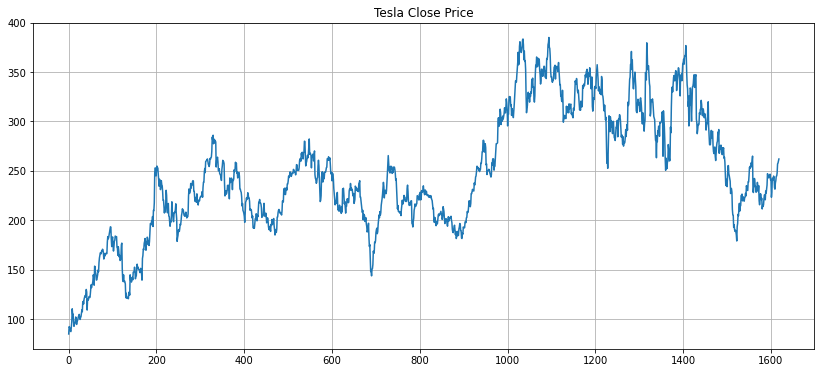

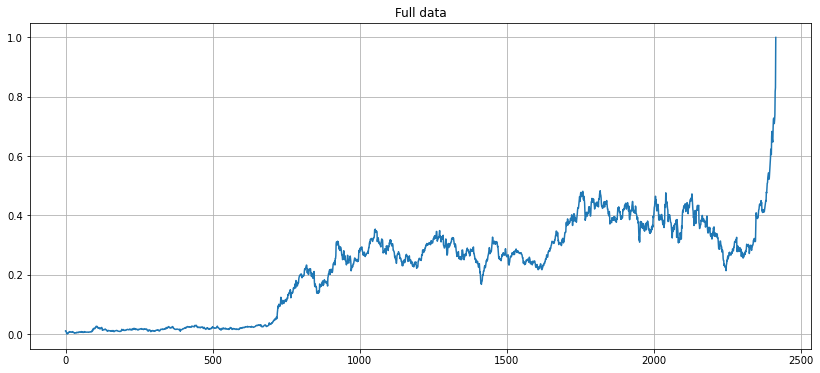

In [15]:
close_price = np.array(a).reshape(-1,1)
plt.figure(figsize=(14,6))
plt.title("Tesla Close Price")
plt.grid()
plt.plot(close_price)

sc = MinMaxScaler()
close_priceSC = sc.fit_transform(np.array(full).reshape(-1,1))
plt.figure(figsize=(14,6))
plt.title("Full data")
plt.grid()
plt.plot(close_priceSC)

In [8]:
X = []
y = []
for i in range(60, len(close_priceSC)):
    X.append(close_priceSC[i-60:i, 0])
    y.append(close_priceSC[i,0])
X, y = np.array(X), np.array(y)
print(X.shape, y.shape)

(1559, 60) (1559,)


In [9]:
border = int(len(X)*0.94)

In [10]:
X_train = X[:border,:]
X_test = X[border:,:]

y_train = y[:border]
y_test = y[border:]

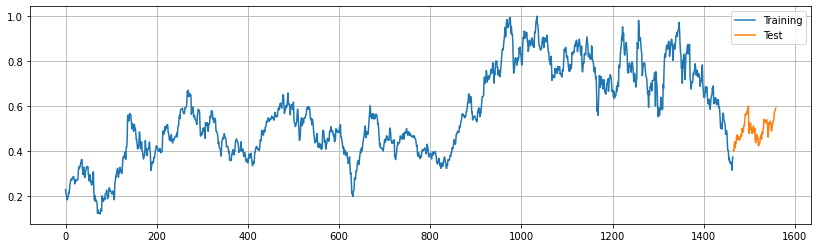

In [12]:
plt.figure(figsize=(14,4))
plt.plot(range(border),y_train)
plt.plot(range(border, len(y)), y_test)
plt.legend(["Training", "Test"])
plt.grid()

In [16]:
print(X_train.shape)
print(X_test.shape)

(1465, 60)
(94, 60)


In [17]:
X_train = X_train.reshape(-1,60,1)
X_test = X_test.reshape(-1,60,1)

In [18]:
print(X_train.shape)
print(X_test.shape)

(1465, 60, 1)
(94, 60, 1)


In [19]:
rnn_model=tf.keras.models.Sequential([
        tf.keras.layers.SimpleRNN(128,activation="relu",return_sequences=True,input_shape=(X_train.shape[1],1)),
        tf.keras.layers.Dropout(0.25),
        tf.keras.layers.SimpleRNN(256,activation="relu",return_sequences=True),
        tf.keras.layers.Dropout(0.25), 
        tf.keras.layers.SimpleRNN(512,activation="relu",return_sequences=True),
        tf.keras.layers.Dropout(0.35),   
        tf.keras.layers.SimpleRNN(256,activation="relu",return_sequences=True),
        tf.keras.layers.Dropout(0.25),
        tf.keras.layers.SimpleRNN(128,activation="relu"),
        tf.keras.layers.Dropout(0.25),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(1)
    ]
)

In [20]:
rnn_model.compile(
    optimizer="adam",
    loss="mean_squared_error"
)
rnn_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, 60, 128)           16640     
_________________________________________________________________
dropout (Dropout)            (None, 60, 128)           0         
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 60, 256)           98560     
_________________________________________________________________
dropout_1 (Dropout)          (None, 60, 256)           0         
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (None, 60, 512)           393728    
_________________________________________________________________
dropout_2 (Dropout)          (None, 60, 512)           0         
_________________________________________________________________
simple_rnn_3 (SimpleRNN)     (None, 60, 256)           1

In [21]:
logdir = "logs/rnn-model"
checkpoint_path = "models/rnn/training__{epoch:02d}__{loss:.4f}/cp.ckpt"

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)
early_stop_callback = tf.keras.callbacks.EarlyStopping(patience=4,monitor='loss')
reduce_lr_callback = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='loss', factor=0.5, patience=2, verbose=1, mode='auto',
    min_delta=0.0001, cooldown=0, min_lr=0
)

In [22]:
with tf.device('/device:GPU:0'):
    rnn_model.fit(
        X_train,
        y_train,
        epochs=100,
        callbacks=[tensorboard_callback, cp_callback, early_stop_callback,reduce_lr_callback],
        batch_size=100,
        initial_epoch=0
)

Epoch 1/100
 1/15 [=>............................] - ETA: 0s - loss: 0.4875WARNING:tensorflow:From C:\Users\User\.conda\envs\tf\lib\site-packages\tensorflow\python\ops\summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
15/15 [==============================] - ETA: 0s - loss: 0.0634
Epoch 00001: saving model to models/rnn/training__01__0.0634\cp.ckpt
15/15 [==============================] - 4s 248ms/step - loss: 0.0634
Epoch 2/100
15/15 [==============================] - ETA: 0s - loss: 0.0124
Epoch 00002: saving model to models/rnn/training__02__0.0124\cp.ckpt
15/15 [==============================] - 3s 210ms/step - loss: 0.0124
Epoch 3/100
15/15 [==============================] - ETA: 0s - loss: 0.0107
Epoch 00003: saving model to models/rnn/training__03__0.0107\cp.ckpt
15/15 [==============================] - 3s 204ms/step - loss: 0.0107
Epoch 

In [23]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
y_pred = rnn_model.predict(X_test)
MSE = mean_absolute_error(y_test, y_pred)

Text(0, 0.5, 'Price')

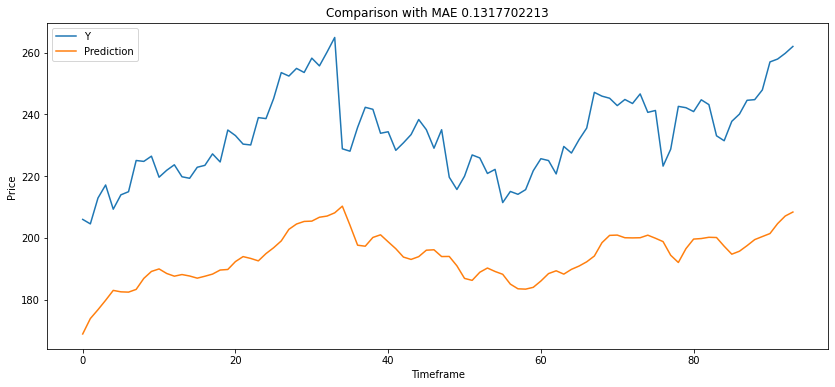

In [24]:
plt.figure(figsize=(14,6))
plt.plot(sc.inverse_transform(y_test.reshape(-1,1)))
plt.plot(sc.inverse_transform(y_pred.reshape(-1,1)))
plt.title("Comparison with MAE {0:0.10f}".format(MSE))
plt.legend(["Y", "Prediction"])
plt.xlabel("Timeframe")
plt.ylabel("Price")

In [3]:
%reload_ext tensorboard
%tensorboard --logdir=logs/ --host=0.0.0.0

Reusing TensorBoard on port 6006 (pid 9432), started 0:00:38 ago. (Use '!kill 9432' to kill it.)

In [13]:
lstm_model=tf.keras.models.Sequential([
        tf.keras.layers.LSTM(64,activation="relu",return_sequences=True,input_shape=(None,1)),
        tf.keras.layers.Dropout(0.25),
        tf.keras.layers.LSTM(128,activation="relu",return_sequences=True),
        tf.keras.layers.Dropout(0.25), 
        tf.keras.layers.LSTM(256,activation="relu",return_sequences=True),
        tf.keras.layers.Dropout(0.35),   
        tf.keras.layers.LSTM(128,activation="relu",return_sequences=True),
        tf.keras.layers.Dropout(0.25),
        tf.keras.layers.LSTM(64,activation="relu"),
        tf.keras.layers.Dropout(0.25),
        tf.keras.layers.Dense(1)
    ]
)

In [27]:
lstm_model.compile(
    optimizer="adam",
    loss="mean_squared_error"
)
lstm_model.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, None, 64)          16896     
_________________________________________________________________
dropout_5 (Dropout)          (None, None, 64)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, None, 128)         98816     
_________________________________________________________________
dropout_6 (Dropout)          (None, None, 128)         0         
_________________________________________________________________
lstm_2 (LSTM)                (None, None, 256)         394240    
_________________________________________________________________
dropout_7 (Dropout)          (None, None, 256)         0         
_________________________________________________________________
lstm_3 (LSTM)                (None, None, 128)        

In [28]:
logdir = "logs/lstm-model"
checkpoint_path = "models/lstm/training__{epoch:02d}__{loss:.4f}/cp.ckpt"

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)
early_stop_callback = tf.keras.callbacks.EarlyStopping(patience=4,monitor='loss')
reduce_lr_callback = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='loss', factor=0.5, patience=2, verbose=1, mode='auto',
    min_delta=0.0001, cooldown=0, min_lr=0.00001
)

In [29]:
with tf.device('/device:GPU:0'):
    lstm_model.fit(
        X_train,
        y_train,
        epochs=100,
        callbacks=[tensorboard_callback, cp_callback, early_stop_callback,reduce_lr_callback],
        batch_size=100,
)

Epoch 1/100
15/15 [==============================] - ETA: 0s - loss: 0.2417
Epoch 00001: saving model to models/lstm/training__01__0.2417\cp.ckpt
15/15 [==============================] - 15s 1s/step - loss: 0.2417
Epoch 2/100
15/15 [==============================] - ETA: 0s - loss: 0.1758
Epoch 00002: saving model to models/lstm/training__02__0.1758\cp.ckpt
15/15 [==============================] - 7s 484ms/step - loss: 0.1758
Epoch 3/100
15/15 [==============================] - ETA: 0s - loss: 0.0481
Epoch 00003: saving model to models/lstm/training__03__0.0481\cp.ckpt
15/15 [==============================] - 7s 483ms/step - loss: 0.0481
Epoch 4/100
15/15 [==============================] - ETA: 0s - loss: 0.0318
Epoch 00004: saving model to models/lstm/training__04__0.0318\cp.ckpt
15/15 [==============================] - 7s 484ms/step - loss: 0.0318
Epoch 5/100
15/15 [==============================] - ETA: 0s - loss: 0.0217
Epoch 00005: saving model to models/lstm/training__05__0.0217\

In [30]:
y_pred = lstm_model.predict(X_test)
print(y_test.shape)
print(y_pred.shape)
MSE = mean_absolute_error(y_test, y_pred)

(94,)
(94, 1)


Text(0, 0.5, 'Price')

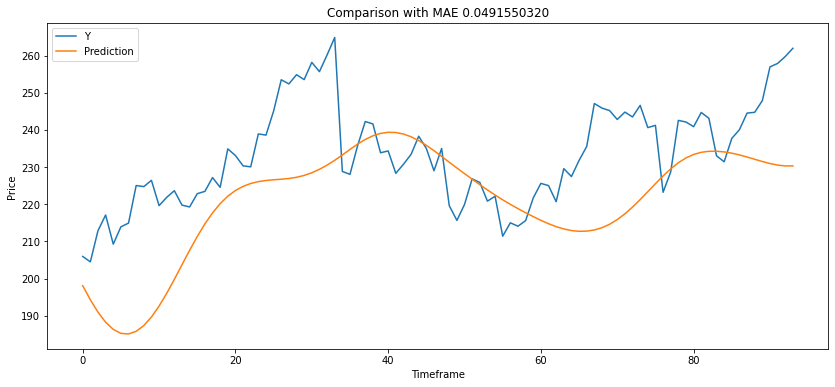

In [31]:
plt.figure(figsize=(14,6))
plt.plot(sc.inverse_transform(y_test.reshape(-1,1)))
plt.plot(sc.inverse_transform(y_pred.reshape(-1,1)))
plt.title("Comparison with MAE {0:0.10f}".format(MSE))
plt.legend(["Y", "Prediction"])
plt.xlabel("Timeframe")
plt.ylabel("Price")

In [4]:
%tensorboard --logdir logs/

Reusing TensorBoard on port 6006 (pid 4104), started 23:01:42 ago. (Use '!kill 4104' to kill it.)

In [38]:
gru_model=tf.keras.models.Sequential([
        tf.keras.layers.GRU(32,activation="relu",return_sequences=True,input_shape=(None,1)),
        tf.keras.layers.Dropout(0.25),
        tf.keras.layers.GRU(64,activation="relu",return_sequences=True),
        tf.keras.layers.Dropout(0.25), 
        tf.keras.layers.GRU(64,activation="relu",return_sequences=True),
        tf.keras.layers.Dropout(0.25),
        tf.keras.layers.GRU(32,activation="relu"),
        tf.keras.layers.Dropout(0.25),
        tf.keras.layers.Dense(1)
    ]
)

In [39]:
gru_model.compile(
    optimizer="adam",
    loss="mean_squared_error"
)
gru_model.summary()


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, None, 32)          3360      
_________________________________________________________________
dropout_10 (Dropout)         (None, None, 32)          0         
_________________________________________________________________
gru_1 (GRU)                  (None, None, 64)          18816     
_________________________________________________________________
dropout_11 (Dropout)         (None, None, 64)          0         
_________________________________________________________________
gru_2 (GRU)                  (None, None, 64)          24960     
_________________________________________________________________
dropout_12 (Dropout)         (None, None, 64)          0         
_________________________________________________________________
gru_3 (GRU)                  (None, 32)               

In [42]:
logdir = "logs/gru-model"
checkpoint_path = "models/gru/training__{epoch:02d}__{loss:.4f}/cp.ckpt"

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)
early_stop_callback = tf.keras.callbacks.EarlyStopping(patience=4,monitor='loss')
reduce_lr_callback = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='loss', factor=0.5, patience=2, verbose=1, mode='auto',
    min_delta=0.0001, cooldown=0, min_lr=0.00001
)

In [43]:
with tf.device('/device:GPU:0'):
    gru_model.fit(
        X_train,
        y_train,
        epochs=100,
        callbacks=[tensorboard_callback, cp_callback, early_stop_callback,reduce_lr_callback],
        batch_size=100,
)

Epoch 1/100
15/15 [==============================] - ETA: 0s - loss: 0.2384
Epoch 00001: saving model to models/gru/training__01__0.2384\cp.ckpt
15/15 [==============================] - 14s 922ms/step - loss: 0.2384
Epoch 2/100
15/15 [==============================] - ETA: 0s - loss: 0.0531
Epoch 00002: saving model to models/gru/training__02__0.0531\cp.ckpt
15/15 [==============================] - 8s 506ms/step - loss: 0.0531
Epoch 3/100
15/15 [==============================] - ETA: 0s - loss: 0.0380
Epoch 00003: saving model to models/gru/training__03__0.0380\cp.ckpt
15/15 [==============================] - 8s 508ms/step - loss: 0.0380
Epoch 4/100
15/15 [==============================] - ETA: 0s - loss: 0.0318
Epoch 00004: saving model to models/gru/training__04__0.0318\cp.ckpt
15/15 [==============================] - 8s 513ms/step - loss: 0.0318
Epoch 5/100
15/15 [==============================] - ETA: 0s - loss: 0.0283
Epoch 00005: saving model to models/gru/training__05__0.0283\cp

In [44]:
y_pred = gru_model.predict(X_test)
MSE = mean_absolute_error(y_test, y_pred)

Text(0, 0.5, 'Price')

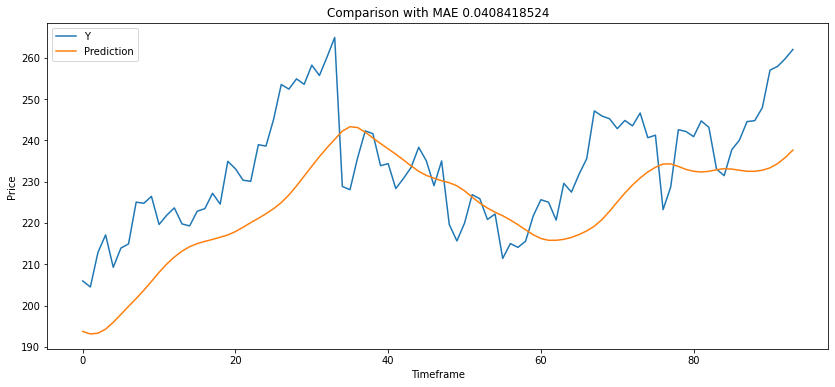

In [45]:
plt.figure(figsize=(14,6))
plt.plot(sc.inverse_transform(y_test.reshape(-1,1)))
plt.plot(sc.inverse_transform(y_pred.reshape(-1,1)))
plt.title("Comparison with MAE {0:0.10f}".format(MSE))
plt.legend(["Y", "Prediction"])
plt.xlabel("Timeframe")
plt.ylabel("Price")

In [5]:
%tensorboard --logdir logs/

Reusing TensorBoard on port 6006 (pid 4104), started 23:01:48 ago. (Use '!kill 4104' to kill it.)